In [1]:
import cv2
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torchvision.transforms as transforms

from src.models.modnet import MODNet

In [16]:
torch_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

print('Load pre-trained MODNet...')
pretrained_ckpt = 'modnet_webcam_portrait_matting.ckpt'
modnet = MODNet(backbone_pretrained=False)
modnet = nn.DataParallel(modnet)


Load pre-trained MODNet...


In [17]:
GPU = True if torch.cuda.device_count() > 0 else False
if GPU:
    print('Use GPU...')
    modnet = modnet.cuda()
    modnet.load_state_dict(torch.load(pretrained_ckpt))
else:
    print('Use CPU...')
    modnet.load_state_dict(torch.load(pretrained_ckpt, map_location=torch.device('cpu')))

modnet.eval()

Use GPU...


DataParallel(
  (module): MODNet(
    (backbone): MobileNetV2Backbone(
      (model): MobileNetV2(
        (features): Sequential(
          (0): Sequential(
            (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): InvertedResidual(
            (conv): Sequential(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): ReLU6(inplace=True)
              (3): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
          )
          (2): InvertedResidual(
            (conv): Sequential(
              (0): C

In [18]:
print('Init WebCam...')
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

print('Start matting...')
while(True):
    _, frame_np = cap.read()
    frame_np = cv2.cvtColor(frame_np, cv2.COLOR_BGR2RGB)
    frame_np = cv2.resize(frame_np, (910, 512), cv2.INTER_AREA)
    frame_np = frame_np[:, 120:792, :]
    frame_np = cv2.flip(frame_np, 1)

    frame_PIL = Image.fromarray(frame_np)
    frame_tensor = torch_transforms(frame_PIL)
    frame_tensor = frame_tensor[None, :, :, :]
    if GPU:
        frame_tensor = frame_tensor.cuda()
    
    with torch.no_grad():
        _, _, matte_tensor = modnet(frame_tensor, True)

    matte_tensor = matte_tensor.repeat(1, 3, 1, 1)
    matte_np = matte_tensor[0].data.cpu().numpy().transpose(1, 2, 0)
    
    background = cv2.imread('backgrounds/background5.jpg')
    background = cv2.resize(background,(matte_np.shape[1],matte_np.shape[0]))
    background = cv2.cvtColor(background,cv2.COLOR_BGR2RGB)
    
    fg_np = matte_np * frame_np + (1 - matte_np) * np.full(frame_np.shape, background)

    fg_np = fg_np.astype(np.uint8)
    fg_np = cv2.cvtColor(fg_np,cv2.COLOR_BGR2RGB)

    cv2.imshow('MODNet - WebCam [Press \'Q\' To Exit]', fg_np)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()
cap.release()
print('Exit...')

Init WebCam...
Start matting...
Exit...


In [8]:
import matplotlib.pyplot as plt
plt.imshow(int(fg_np))

TypeError: only size-1 arrays can be converted to Python scalars

In [27]:
x = fg_np.astype(np.uint8)
y = np.unique(x)

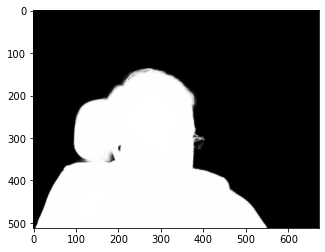

In [85]:
plt.imshow(matte_np)

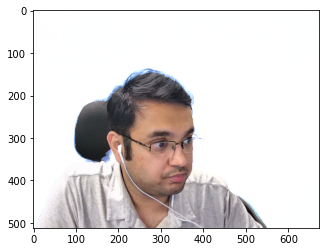

In [84]:
a = cv2.add(fg_np,background)
plt.imshow(a)

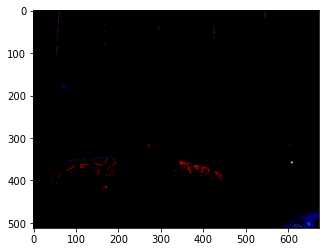

In [64]:
z = x.copy()
z[x255] = 0
plt.imshow(z)

In [55]:
y

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

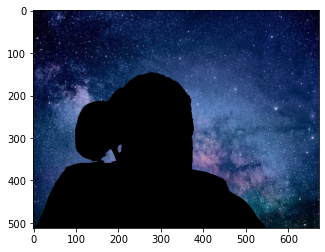

In [82]:
# background = cv2.imread('backgrounds/background6.jpg')
background = cv2.cvtColor(background,cv2.COLOR_BGR2RGB)
# background = cv2.resize(background,(x.shape[1],x.shape[0]))
# background[matte_np>=0.7]=0
plt.imshow(background)

In [ ]:
view_np = cv2.add(background,fg_np)